<a href="https://colab.research.google.com/github/jan-felix/SLOG/blob/master/Metculus_and_Dawum_Scraper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 %%capture
!pip install --progress-bar off --quiet poetry
!pip install --progress-bar off --quiet git+https://github.com/oughtinc/ergo.git
import os
os._exit(00)

In [1]:
import pandas as pd
import ergo
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
import pandas_datareader as pdr
import datetime
import os

/usr/local/lib/python3.7/dist-packages/ergo/ppl.py:15: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
metaculus = ergo.Metaculus()

# Get Predictions

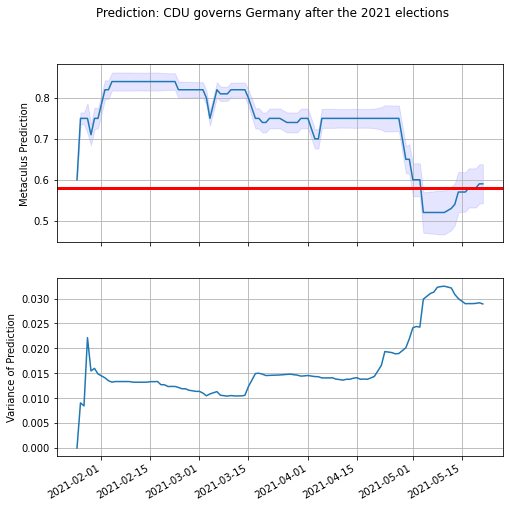

In [3]:
my_pred = 0.58
question_id = 6338
question_name = "Prediction: CDU governs Germany after the 2021 elections"
#def metaculus_question_plot(question_id,question_name,my_pred):
 
binary="yes"
 
#Retrieve and Format Data
question = metaculus.get_question(question_id, name=question_name)
title = question.data["title"]
n_predictions = question.data["number_of_predictions"]
data_hist = question.data["prediction_histogram"]
 
data_ts = pd.DataFrame(question.data["prediction_timeseries"])
data_ts.index = pd.to_datetime(data_ts["t"],unit="s")
data_ts.index = pd.DatetimeIndex(data_ts.index.strftime('%Y-%m-%d'))
data_ts.index.name = None
data_ts = data_ts.drop(columns="t")
data_ts = data_ts.groupby(data_ts.index).last()
 
hist_dist = pd.DataFrame(data_ts["distribution"].tolist())
hist_dist = hist_dist.drop(columns = "num")
hist_dist.index = data_ts.index
hist_dist = hist_dist.groupby(hist_dist.index).last()
 
data_ts["Upper90"] = 1.65*hist_dist["var"]+data_ts["community_prediction"]
data_ts["Lower90"] = -1.65*hist_dist["var"]+data_ts["community_prediction"]
 
fig, axs = plt.subplots(2,1,figsize =(8,8),sharex=True)
fig.suptitle(question_name)
axs[0].plot(data_ts["community_prediction"])
axs[0].fill_between(data_ts["community_prediction"].index, data_ts["Lower90"], data_ts["Upper90"], color='b', alpha=.1)
axs[0].grid()
axs[0].set_ylabel('Metaculus Prediction')
axs[0].axhline(my_pred, linewidth=3, color='r')
axs[1].plot(hist_dist["var"])
axs[1].set_ylabel('Variance of Prediction')
axs[1].grid()
fig.autofmt_xdate()

# Get recent Dawum Data

In [4]:
table_dawum_verlauf = pd.read_html('https://dawum.de/Bundestag/#Umfrageverlauf')
recent_polls = pd.DataFrame(table_dawum_verlauf[0]).set_index(0).dropna(axis=1)
recent_polls.columns = ["Current","Change"]
recent_polls.index.name = None
recent_polls

,Current,Change
CDU/CSU,"25,4%","(+0,6)"
Grüne,"24,2%","(−1,0)"
SPD,"15,1%",(±0)
FDP,"11,3%",(±0)
AfD,"10,6%","(+0,1)"
Linke,"6,8%",(±0)
Freie Wähler,"2,5%",(—)


In [5]:
meta_poll_data = pd.DataFrame(table_dawum_verlauf[1]).set_index(0)
meta_poll_data.columns = ["Value"]
meta_poll_data.index.name = None
meta_poll_data

,Value
Durchschnitt:,8 Wahlumfragen
Gewichtung:,letzter Befragungstag
Veröffentlichung:,12. - 21.05.
Befragte:,19978
Vergleich:,zum 12.05.


# Scrape Dawum Chronik

In [6]:
URL = 'https://dawum.de/Bundestag/#Vergleich_mit_Wahlergebnis'
page = requests.get(URL)
#Get Soup
soup = BeautifulSoup(page.content, 'html.parser')
chronik = soup.find(id="Chronik")
table = chronik.find("div",attrs={"class": "table"})
#Create Table
df = pd.DataFrame()
rows = table.findAll("a")
table_list = []
for row in rows: 
  cols = row.findAll("div")
  row_list = []
  for div in cols:
    row_list.append(div.get_text())
  table_list.append(row_list)
 
#Format Data 
rawr_data = pd.DataFrame(table_list)
dates = rawr_data[0].str[0:10]
institute =rawr_data[0].str[10:]
 
rawr_data.columns = ["Institute","Union","Greens","SPD","AFD","FDP","Linke","Freie Wähler","Sonstige"]
 
institute = institute.str.replace('\xad', '') 
institute = [s.strip() for s in institute]
rawr_data["Institute"] = institute

rawr_data.index = pd.DatetimeIndex(pd.to_datetime(dates, dayfirst = True))
rawr_data.index.name = None
rawr_data.drop("Freie Wähler", axis=1)
cols = ["Union","Greens","SPD","AFD","FDP","Linke","Sonstige"]
rawr_data[cols] = rawr_data[cols].apply(lambda x: x.str.replace(',', '.').astype(float), axis=1)
rawr_data = rawr_data.sort_index()

rawr_data = rawr_data.ewm(halflife = 3).mean()


In [7]:
%%capture
rawr_data["Union"].plot()

In [8]:
%%capture
union_vs_greens = rawr_data[["Union","Greens"]]
union_vs_greens["Union-Greens"] = rawr_data["Union"]-rawr_data["Greens"]

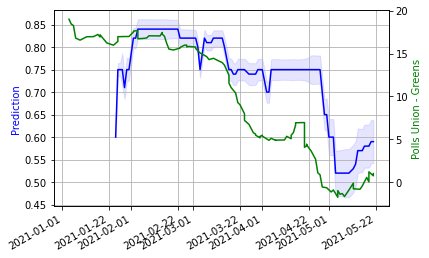

In [9]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(data_ts["community_prediction"], "-b")
ax1.fill_between(data_ts["community_prediction"].index, data_ts["Lower90"], data_ts["Upper90"], color='b', alpha=.1)
ax2.plot(union_vs_greens["Union-Greens"],"-g")

ax1.set_ylabel('Prediction', color='b')
ax2.set_ylabel('Polls Union - Greens', color='g')
ax1.grid()
fig.autofmt_xdate()
plt.show()

In [10]:
start = datetime.datetime(2021, 1, 1)
end = datetime.datetime.today()
index = pd.date_range(start, end, freq="D")
os.environ["ALPHAVANTAGE_API_KEY"] = "H6AXUXK0Z2CBTV59"

ger = pdr.av.time_series.AVTimeSeriesReader(symbols = "EWG",start = start, end = end).read()["close"]
emu = pdr.av.time_series.AVTimeSeriesReader(symbols = "IVV",start = start, end = end).read()["close"]

In [11]:
indices = pd.concat([ger,emu],axis=1)
indices.columns = ["Germany","EMU"]
indices = indices/indices.iloc[0,:]*100
indices["GER/EMU"] = indices["Germany"]/indices["EMU"]
indices.index = pd.DatetimeIndex(indices.index)
index_vs_politics = pd.merge(union_vs_greens, indices, left_index= True, right_index=True)
index_vs_politics = index_vs_politics.drop_duplicates(subset="GER/EMU",keep="last")

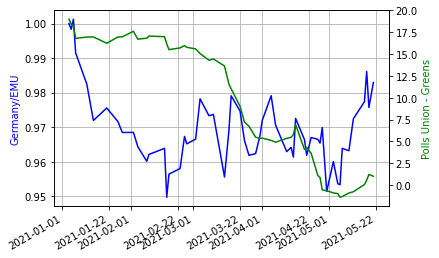

In [12]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(index_vs_politics["GER/EMU"], "-b")
ax2.plot(index_vs_politics["Union-Greens"],"-g")

ax1.set_ylabel('Germany/EMU', color='b')
ax2.set_ylabel('Polls Union - Greens', color='g')
ax1.grid()
fig.autofmt_xdate()
plt.show()

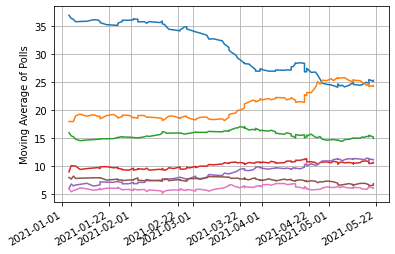

In [15]:
fig, ax = plt.subplots()

ax.plot(rawr_data[["Union","Greens","SPD","AFD","FDP","Linke","Sonstige"]])
ax.set_ylabel('Moving Average of Polls')
ax.grid()
fig.autofmt_xdate()
plt.show()

This chart shows stock returns of MSCI Germany vs MSCI EMU vs the poll gap between Union-Greens.

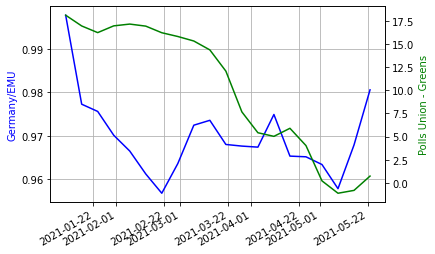

In [16]:
index_vs_politics = index_vs_politics.resample('W').mean()
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(index_vs_politics["GER/EMU"], "-b")
ax2.plot(index_vs_politics["Union-Greens"],"-g")

ax1.set_ylabel('Germany/EMU', color='b')
ax2.set_ylabel('Polls Union - Greens', color='g')
ax1.grid()
fig.autofmt_xdate()
plt.show()

This is the same analysis with weekly means for polls and index values. This will be useful for the statistical analysis as it screens out some noise.

# Is the strength of the Greens predictive of stockprices?  

In [17]:
import statsmodels.api as sm

index_vs_politics_diff = index_vs_politics.diff().dropna()

Y = index_vs_politics_diff["GER/EMU"]
X = index_vs_politics_diff["Union-Greens"]
mod = sm.OLS(endog=Y, exog=X)

res = mod.fit()

print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                GER/EMU   R-squared (uncentered):                   0.052
Model:                            OLS   Adj. R-squared (uncentered):             -0.001
Method:                 Least Squares   F-statistic:                             0.9778
Date:                Sat, 22 May 2021   Prob (F-statistic):                       0.336
Time:                        05:59:53   Log-Likelihood:                          66.063
No. Observations:                  19   AIC:                                     -130.1
Df Residuals:                      18   BIC:                                     -129.2
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))


So far no predictive value of polls for MSCI Germany/MSCI EMU.